In [237]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from datetime import date
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm


/anaconda3/envs/python36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Create regression data

In [6]:
tfidf_path = '../../data/tfidf_toprev_conlen_fulldata/'

In [7]:
lda_path = '../../data/lda_jsd_toprev_conlen/'

In [8]:
tag_path = '../../data/tag_novelty_full/'

In [31]:
fandom_list = ['harry_potter',
 'dcu',
 'doctor_who_&_related_fandoms',
 'star_wars_all_media_types',
 'arthurian_mythology_&_related_fandoms',
 'supernatural',
 'haikyuu',
 'kuroko_no_basuke',
 'hamilton_miranda',
 'dragon_age_all_media_types',
 'the_walking_dead_&_related_fandoms',
 'buffy_the_vampire_slayer',
 'les_miserables_all_media_types',
 'naruto',
 'tolkien_j_r_r_works_&_related_fandoms',
 'shakespare_william_works',
 'hetalia_axis_powers',
 'attack_on_titan',
 'ms_paint_adventures',
 'homestuck',
 'marvel',
 'bishoujo_senshi_sailor_moon',
 'one_direction',
 'sherlock_holmes_&_related_fandoms']

In [247]:
df_all = []
for i,fandom in enumerate(fandom_list):
    df_tfidf = pd.read_csv(os.path.join(tfidf_path,fandom + '_temporal_tfidf_cos_toprev_conlen.tsv'), sep = '\t')
    del df_tfidf['index']
    df_lda = pd.read_csv(os.path.join(lda_path,fandom + '_temporal_lda_jsd_toprev_full.tsv'), sep = '\t')
    del df_lda['index']
    df_tag = pd.read_csv(os.path.join(tag_path,fandom + '_tag_novelty_conlen_full.tsv'), sep = '\t')
    df = pd.merge(df_tfidf, df_lda, on=['AdditionalTags', 'ArchiveWarnings', 'Author', 'Bookmarks', 'Category',\
 'ChapterIndex', 'Chapters' ,'Characters','Comments' ,'CompleteDate',\
 'Fandoms', 'Hits' ,'Kudos', 'Language', 'Notes' ,'PublishDate' ,'Rating',\
 'Relationship' ,'Summary' ,'Title' ,'URL' ,'UpdateDate' ,'Words'], how='inner')
    df = pd.merge(df, df_tag, on=['AdditionalTags', 'ArchiveWarnings', 'Author', 'Bookmarks', 'Category',\
 'ChapterIndex', 'Chapters' ,'Characters','Comments' ,'CompleteDate',\
 'Fandoms', 'Hits' ,'Kudos', 'Language', 'Notes' ,'PublishDate' ,'Rating',\
 'Relationship' ,'Summary' ,'Title' ,'URL' ,'UpdateDate' ,'Words'], how='inner')
    
    df['fandom_category'] = fandom
    df['tag_novelty'] = df['tag_novelty'] * 100
    
    df['Kudos'] = df['Kudos']/df['Chapters']
    df['Kudos'] = np.log(df['Kudos'])
    df['Hits'] = df['Hits']/df['Chapters']
    df['Bookmarks'] = df['Kudos']/df['Chapters']

#     df = df.dropna(subset=['Kudos'])
#     df = df[np.isfinite(df['Kudos'])]
#     df['Kudos'] = (df['Kudos'] - df['Kudos'].mean())/df['Kudos'].std(ddof=0)

    df_all.append(df)

In [248]:
df_all = pd.concat(df_all)

In [249]:
df_all.head(2)

,AdditionalTags,ArchiveWarnings,Author,Bookmarks,Category,ChapterIndex,Chapters,Characters,Comments,CompleteDate,...,Relationship,Summary,Title,URL,UpdateDate,Words,Cos,JSD,tag_novelty,fandom_category
0,"Missing Scene, Work In Progress",No Archive Warnings Apply,tag0,0.326943,Gen,1.0,3,"Severus Snape, Harry Potter, Remus Lupin, Siri...",0,NaN,...,NaN,Snape\'s reactions to the events in <u>Harry P...,The Marauders\' Secrets,http://archiveofourown.org/works/941023/chapte...,2004-06-25,4349.0,0.778655,0.599456,-0.012112,harry_potter
1,D/s,No Archive Warnings Apply,kaiz,2.944439,M/M,NaN,1,NaN,1,2003-03-24,...,Harry Potter/Severus Snape,Harry receives special lessons in love and trust,Native Tongue,http://archiveofourown.org/works/90296?view_ad...,NaN,653.0,0.879855,0.625602,NaN,harry_potter


In [250]:
del df_all['Language']
del df_all['Notes']
del df_all['Summary']
del df_all['Title']
del df_all['URL']
del df_all['AdditionalTags']
del df_all['Fandoms']
del df_all['Characters']
del df_all['Words']

In [251]:
def first_relationship(field):
    try:
        return field.split(',')[0]
    except:
        return field

In [252]:
df_all['Relationship'] = df_all.apply(lambda row: first_relationship(row['Relationship']), axis=1)

In [253]:
df_all['ArchiveWarnings'] = df_all['ArchiveWarnings'].astype('category')
df_all['ArchiveWarnings_cat'] = df_all['ArchiveWarnings'].cat.codes
del df_all['ArchiveWarnings']

In [254]:
df_all['Author'] = df_all['Author'].astype('category')
df_all['Author_cat'] = df_all['Author'].cat.codes
del df_all['Author']

In [255]:
df_all['Category'] = df_all['Category'].astype('category')
df_all['Category_cat'] = df_all['Category'].cat.codes
del df_all['Category']

In [256]:
df_all['Rating'] = df_all['Rating'].astype('category')
df_all['Rating_cat'] = df_all['Rating'].cat.codes
del df_all['Rating']

In [257]:
df_all['Relationship'] = df_all['Relationship'].astype('category')
df_all['Relationship_cat'] = df_all['Relationship'].cat.codes
del df_all['Relationship']

In [258]:
df_all['fandom_category'] = df_all['fandom_category'].astype('category')
df_all['Fandom_cat'] = df_all['fandom_category'].cat.codes
del df_all['fandom_category']

In [259]:
def date_today(cell):
    try:
        y, m, d = cell.split('-')
        return abs(date.today() - date(int(y), int(m), int(d))).days
    except:
        return float('nan')

In [260]:
df_all['PublishDate'] = df_all.apply(lambda row: date_today(row['PublishDate']), axis = 1)

In [261]:
df_all['CompleteDate'] = df_all.apply(lambda row: date_today(row['CompleteDate']), axis = 1)

In [262]:
df_all['UpdateDate'] = df_all.apply(lambda row: date_today(row['UpdateDate']), axis = 1)

In [263]:
def find_history(field_list):
    field_list = [10000000 if np.isnan(x) else x for x in field_list]
    return np.amin(field_list)

In [264]:
df_all['history'] = df_all.apply(lambda row: find_history([row['PublishDate'], row['CompleteDate'], row['UpdateDate']]), axis=1)

In [265]:
del df_all['PublishDate']
del df_all['CompleteDate']
del df_all['UpdateDate']

In [266]:
df_all.head()

,Bookmarks,ChapterIndex,Chapters,Comments,Hits,Kudos,Cos,JSD,tag_novelty,ArchiveWarnings_cat,Author_cat,Category_cat,Rating_cat,Relationship_cat,Fandom_cat,history
0,0.326943,1.0,3,0,106.666667,0.980829,0.778655,0.599456,-0.012112,120,75011,147,1,-1,9,5093.0
1,2.944439,NaN,1,1,1359.000000,2.944439,0.879855,0.625602,NaN,120,59314,239,2,10910,9,5552.0
2,NaN,NaN,1,0,60.000000,NaN,0.332479,0.573035,NaN,120,78501,63,1,10546,9,5553.0
3,2.484907,NaN,1,0,495.000000,2.484907,0.795259,0.650978,-0.006056,120,32036,239,5,22894,9,5556.0
4,3.637586,NaN,1,3,737.000000,3.637586,0.934369,0.644082,-0.006921,120,56127,349,0,24319,9,5558.0


### Correlations

In [267]:
corr = df_all[['Bookmarks', 'Chapters', 'Comments', 'Hits', 'Kudos', 'Cos', 'JSD', 'tag_novelty', 'history']].corr()

In [269]:
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,Bookmarks,Chapters,Comments,Hits,Kudos,Cos,JSD,tag_novelty,history
Bookmarks,1,-0.3,0.2,0.47,0.71,-0.066,-0.034,-0.072,0.16
Chapters,-0.3,1,0.093,-0.1,-0.26,-0.0045,0.021,0.038,-0.12
Comments,0.2,0.093,1,0.31,0.42,-0.074,-0.063,0.011,-0.056
Hits,0.47,-0.1,0.31,1,0.48,-0.041,-0.045,0.042,0.13
Kudos,0.71,-0.26,0.42,0.48,1,-0.14,-0.099,-0.045,0.049
Cos,-0.066,-0.0045,-0.074,-0.041,-0.14,1,0.11,0.051,0.079
JSD,-0.034,0.021,-0.063,-0.045,-0.099,0.11,1,-0.0011,0.068
tag_novelty,-0.072,0.038,0.011,0.042,-0.045,0.051,-0.0011,1,0.18
history,0.16,-0.12,-0.056,0.13,0.049,0.079,0.068,0.18,1


### OLS

In [270]:
df_all.columns.values

array(['Bookmarks', 'ChapterIndex', 'Chapters', 'Comments', 'Hits',
       'Kudos', 'Cos', 'JSD', 'tag_novelty', 'ArchiveWarnings_cat',
       'Author_cat', 'Category_cat', 'Rating_cat', 'Relationship_cat',
       'Fandom_cat', 'history'], dtype=object)

In [271]:
df_all = df_all.dropna(how = 'any')

In [301]:
model = ols("Kudos ~  Chapters + Cos + JSD + tag_novelty + ArchiveWarnings_cat\
+ Author_cat + Category_cat + Rating_cat + Relationship_cat + Fandom_cat + history", data=df_all).fit()

In [302]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Kudos   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     4045.
Date:                Tue, 05 Jun 2018   Prob (F-statistic):               0.00
Time:                        15:54:33   Log-Likelihood:            -6.1832e+05
No. Observations:              354978   AIC:                         1.237e+06
Df Residuals:                  354966   BIC:                         1.237e+06
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               3.1245    

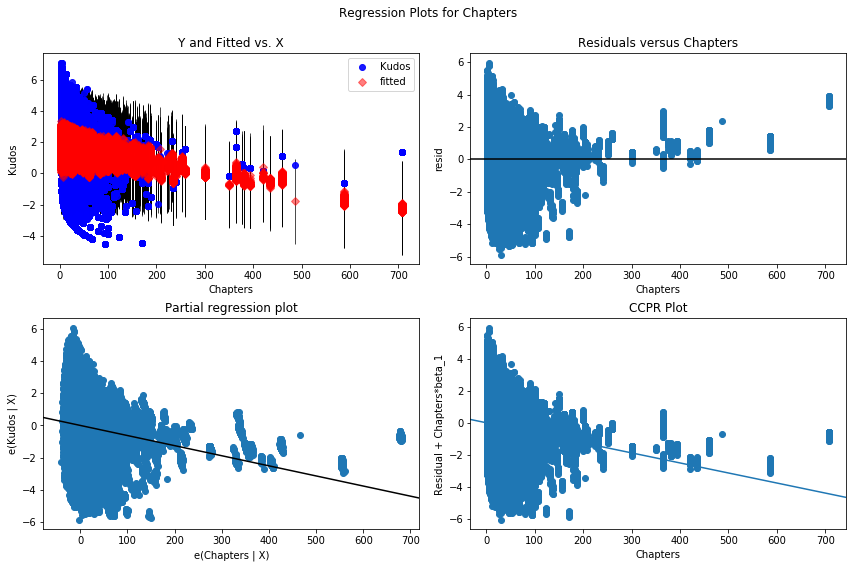

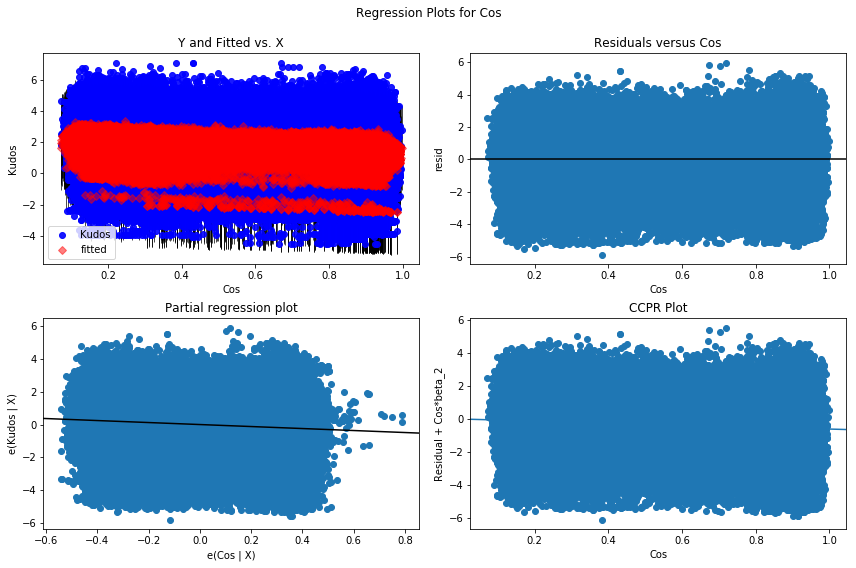

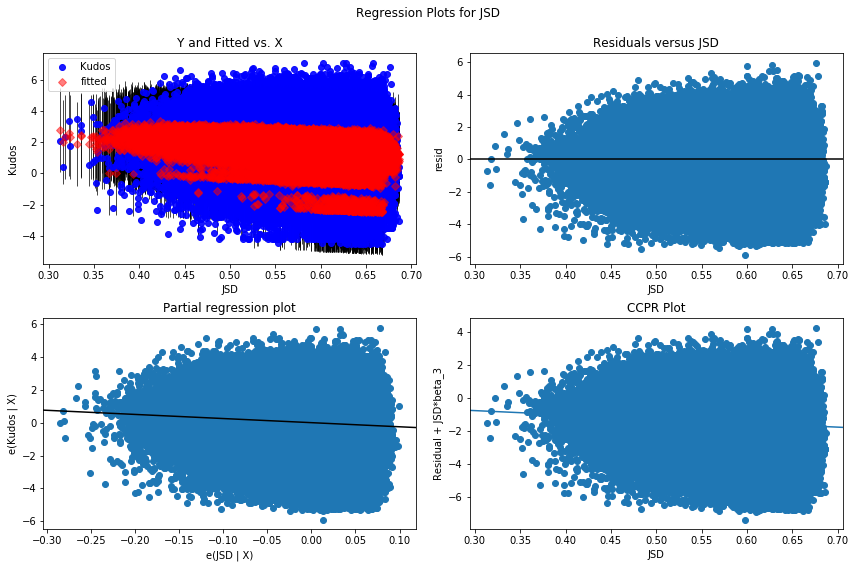

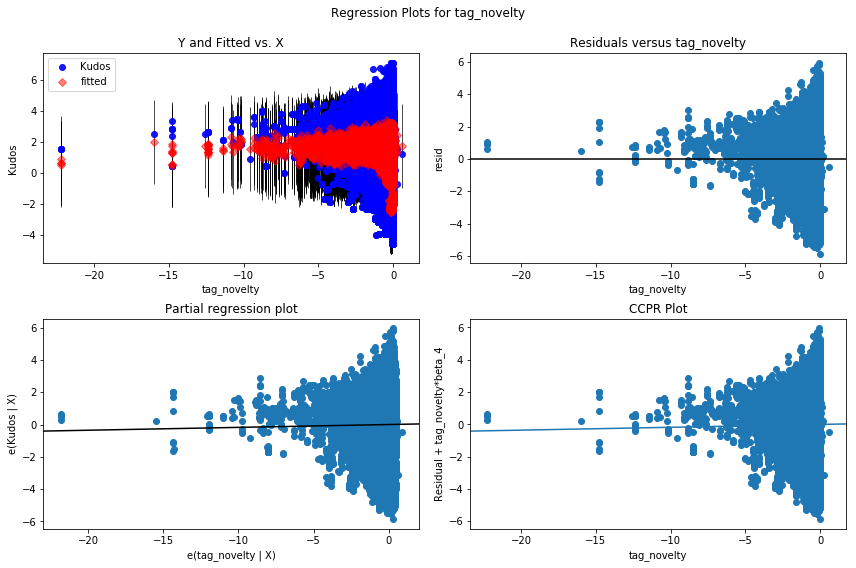

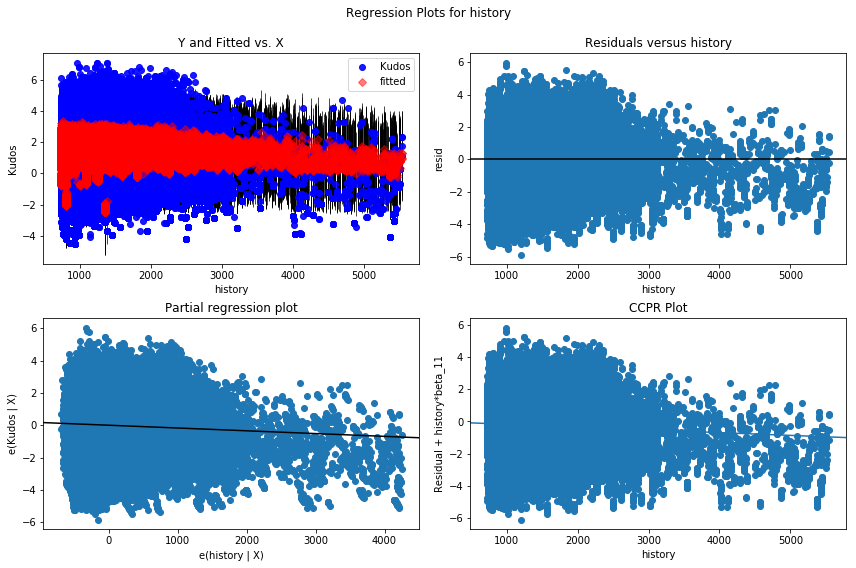

In [303]:
for item in ['Chapters','Cos', 'JSD', 'tag_novelty', 'history']:
    fig = plt.figure(figsize=(12,8))
    fig = sm.graphics.plot_regress_exog(model, item, fig=fig)

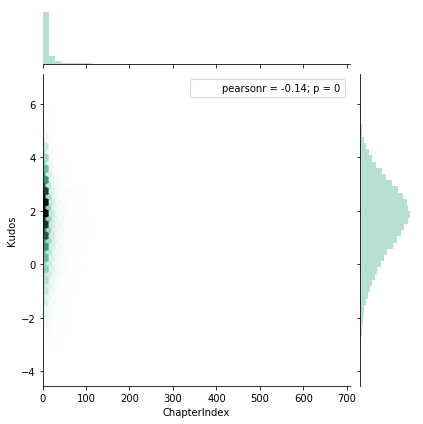

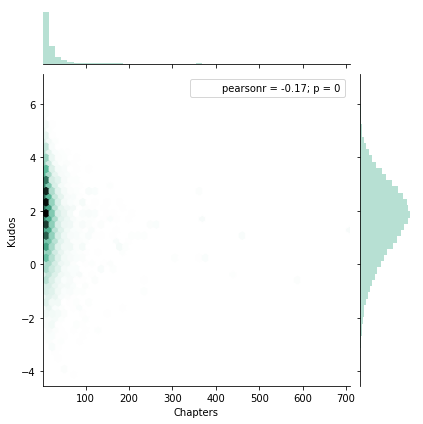

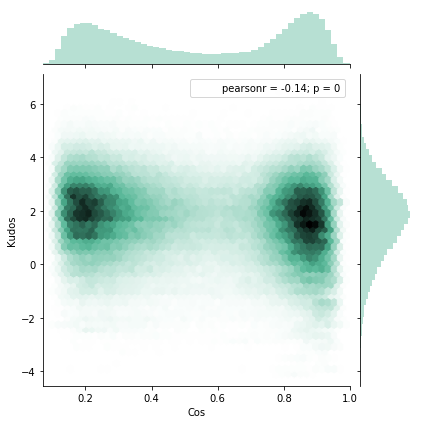

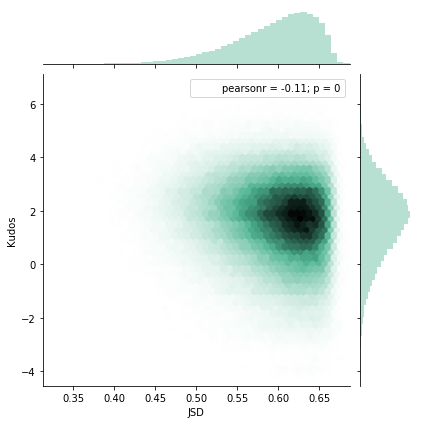

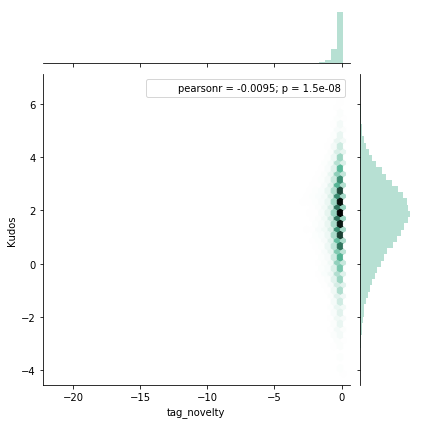

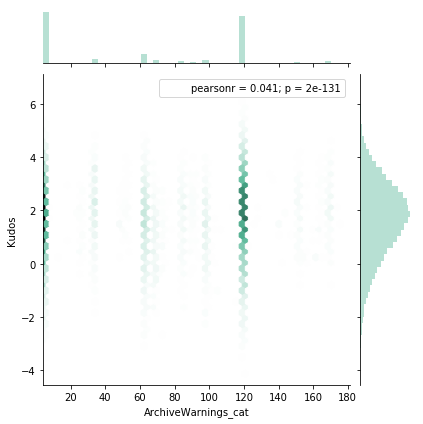

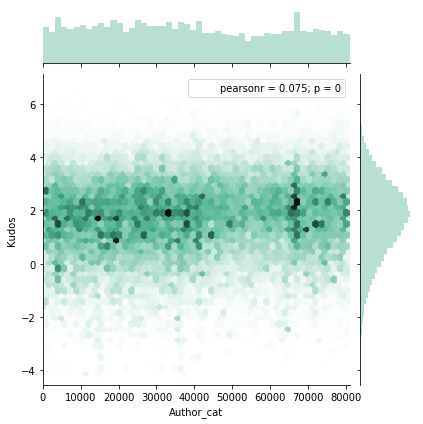

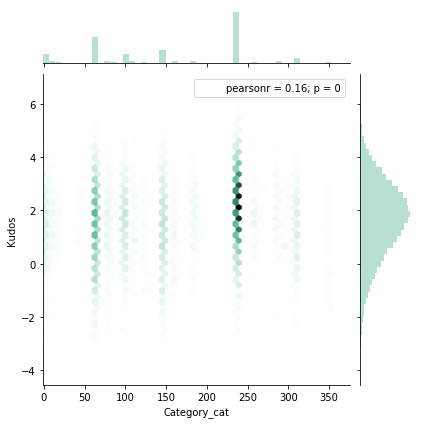

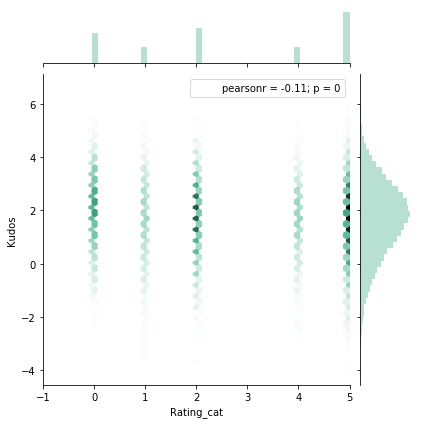

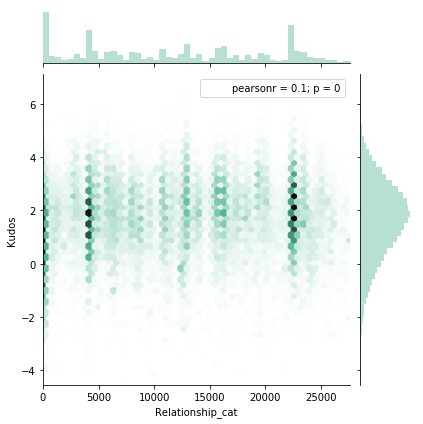

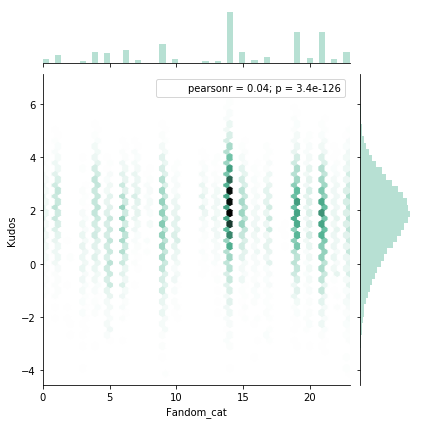

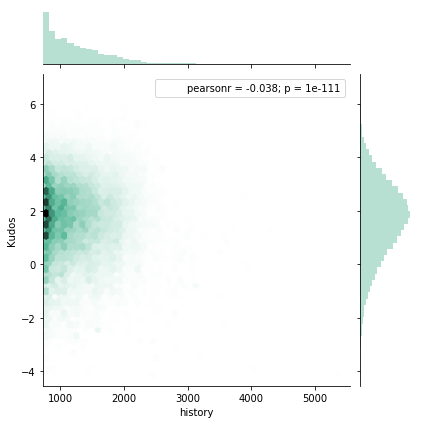

In [275]:
for item in ['ChapterIndex', 'Chapters','Cos', 'JSD', 'tag_novelty', 'ArchiveWarnings_cat',\
       'Author_cat', 'Category_cat', 'Rating_cat', 'Relationship_cat','Fandom_cat', 'history']:
    sns.jointplot(df_all[item], df_all['Kudos'], kind="hex", color="#4CB391")